## PyDDA XSAPR notebook

In [1]:
import pydda
import pyart

from netCDF4 import Dataset
from boto.s3.connection import S3Connection
from unravel import dealias
from dask_jobqueue import PBSCluster
from distributed import Client
from glob import glob
from datetime import datetime
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/docrep/__init__.py:24: DeprecationWarning: Flags not at the start of the expression '(?<!%)(%%)*%(?!%)   ' (truncated)
  \((?P<key>(?s).*?)\)# key enclosed in brackets""", re.VERBOSE)


Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
xsapr_i6_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI6.00/201805/XNW180531061508.RAWU5DS'
xsapr_i4_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI4.00/201805/XSE180531061517.RAWFLUV'
sonde_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpsondewnpnC1.b1/sgpsondewnpnC1.b1.20180530.233300.cdf'

In [3]:
radar_i6 = pyart.io.read(xsapr_i6_path)
radar_i4 = pyart.io.read(xsapr_i4_path)

In [4]:
disp_radar_i6 = pyart.graph.RadarMapDisplay(radar_i6)
disp_radar_i4 = pyart.graph.RadarMapDisplay(radar_i4)

In [5]:
radar_i6.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase'])

In [6]:
gf_i6 = pyart.filters.GateFilter(radar_i6)
gf_i6.exclude_below('normalized_coherent_power', 0.5)
gf_i6.exclude_below('cross_correlation_ratio', 0.9)
gf_i6 = pyart.correct.despeckle_field(radar_i6, 'velocity', size=100, gatefilter=gf_i6)

gf_i4 = pyart.filters.GateFilter(radar_i4)
gf_i4.exclude_below('normalized_coherent_power', 0.5)
gf_i4.exclude_below('cross_correlation_ratio', 0.9)
gf_i4 = pyart.correct.despeckle_field(radar_i4, 'velocity', size=100, gatefilter=gf_i4)

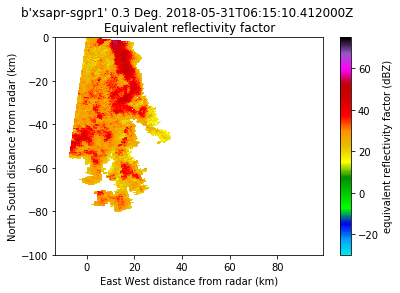

In [7]:
disp_radar_i6.plot_ppi('reflectivity', gatefilter=gf_i6)

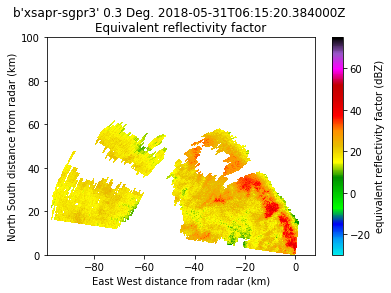

In [8]:
disp_radar_i4.plot_ppi('reflectivity', gatefilter=gf_i4)

In [ ]:
disp_radar_i6.plot_ppi('velocity', gatefilter=gf_i6)

In [ ]:
disp_radar_i4.plot_ppi('velocity', gatefilter=gf_i4)

In [ ]:
sonde_cdf = Dataset(sonde_path, mode='r')
print(sonde_cdf.variables.keys())
height = sonde_cdf.variables['alt'][:]
spd = sonde_cdf.variables['wspd'][:]
direction = sonde_cdf.variables['deg'][:]
u_back = sonde_cdf.variables['u_wind'][:]
v_back = sonde_cdf.variables['v_wind'][:]

plt.plot(spd, height)
profile = pyart.core.HorizontalWindProfile(height, spd, direction)
sim_vel_i4 = pyart.util.simulated_vel_from_profile(radar_i4, profile)
sim_vel_i6 = pyart.util.simulated_vel_from_profile(radar_i6, profile)
radar_i4.add_field('sim_vel', sim_vel_i4, replace_existing=True)
radar_i6.add_field('sim_vel', sim_vel_i6, replace_existing=True)

In [ ]:
disp_radar_i4.plot_ppi('sim_vel', 1, gatefilter=gf_i4)

In [ ]:
radar_i4.fields['velocity']['data'] = -radar_i4.fields['velocity']['data']
radar_i6.fields['velocity']['data'] = -radar_i6.fields['velocity']['data']
region_based_i4 = pyart.correct.dealias_region_based(radar_i4, gatefilter=gf_i4, rays_wrap_around=False,
                                                     interval_splits=3, centered=True, skip_along_ray=2000, ref_vel_field='sim_vel')
region_based_i6 = pyart.correct.dealias_region_based(radar_i6, gatefilter=gf_i6, rays_wrap_around=False,
                                                     interval_splits=3, centered=True, skip_along_ray=2000, ref_vel_field='sim_vel')
radar_i4.add_field('corrected_velocity', region_based_i4, replace_existing=True)
radar_i6.add_field('corrected_velocity', region_based_i6, replace_existing=True)

In [ ]:
## Add an extra step for continuity?
nyquist_interval = radar_i4.instrument_parameters['nyquist_velocity']['data'][0]*2
mean_vel = np.zeros((radar_i4.nsweeps))
mean_sim_vel = np.zeros((radar_i4.nsweeps))
for i in range(radar_i4.nsweeps):
    the_sweep = radar_i4.get_slice(i)
    mean_vel[i] = radar_i4.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
    mean_sim_vel[i] = radar_i4.fields['sim_vel']['data'][the_sweep].mean()/nyquist_interval
    
for i in range(1, radar_i4.nsweeps):
    if(abs(mean_vel[i]-mean_vel[i-1]) > 0.75):
        the_sweep = radar_i4.get_slice(i)
        radar_i4.fields['corrected_velocity']['data'][the_sweep] -= round(mean_vel[i]-mean_vel[i-1])*nyquist_interval
        mean_vel[i] = radar_i4.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
plt.plot(mean_vel)
plt.plot(mean_sim_vel)

In [ ]:
## Add an extra step for continuity?
nyquist_interval = radar_i6.instrument_parameters['nyquist_velocity']['data'][0]*2
mean_vel = np.zeros((radar_i6.nsweeps))
mean_sim_vel = np.zeros((radar_i6.nsweeps))
for i in range(radar_i6.nsweeps):
    the_sweep = radar_i6.get_slice(i)
    mean_vel[i] = radar_i6.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
    mean_sim_vel[i] = radar_i6.fields['sim_vel']['data'][the_sweep].mean()/nyquist_interval
    
for i in range(1, radar_i6.nsweeps):
    if(abs(mean_vel[i]-mean_vel[i-1]) > 0.75):
        the_sweep = radar_i6.get_slice(i)
        radar_i6.fields['corrected_velocity']['data'][the_sweep] -= round(mean_vel[i]-mean_vel[i-1])*nyquist_interval
        mean_vel[i] = radar_i6.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
plt.plot(mean_vel)
plt.plot(mean_sim_vel)

In [ ]:
plt.figure(figsize=(5,60))
plt.subplot(15,1,1)
for i in range(15):
    plt.subplot(15,1,i+1)
    disp_radar_i4.plot_ppi('corrected_velocity', gatefilter=gf_i4, cmap='pyart_NWSVel', sweep=i, vmin=-30, vmax=30)

In [ ]:
disp_radar_i6.plot_ppi('corrected_velocity', 9, gatefilter=gf_i6, cmap='pyart_NWSVel')

In [3]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=False):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Barnes',
        gridding_algo='map_gates_to_grid',
        toa=20000.0,
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb, 
        gatefilters=[gatefilter])
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [ ]:
grid_i4 = grid_radar(radar_i4, 
                        origin=(radar_i4.latitude['data'][0], radar_i4.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 161, 241), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, gatefilter=gf_i4,
                        )
grid_i6 = grid_radar(radar_i6, 
                        origin=(radar_i4.latitude['data'][0], radar_i4.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 161, 241), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, gatefilter=gf_i6,
                        )

In [ ]:
disp_grid_i4 = pyart.graph.GridMapDisplay(grid_i4)
disp_grid_i4.plot_grid('corrected_velocity', 7,cmap='pyart_NWSVel')

In [ ]:
disp_grid_i4 = pyart.graph.GridMapDisplay(grid_i4)
disp_grid_i4.plot_grid('corrected_velocity', 12, vmin=-20, vmax=20)

In [ ]:
disp_grid_i6.plot_latitudinal_level('corrected_velocity', 200, cmap='pyart_NWSVel')
plt.xlim([-30,30])

In [ ]:
disp_grid_i4.plot_latitudinal_level('corrected_velocity', 250, cmap='pyart_NWSVel', vmin=-30, vmax=30)
plt.xlim([-100,30])

In [ ]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_i4, (0.0,0.0,0.0))
new_grids = pydda.retrieval.get_dd_wind_field([grid_i4, grid_i6], u_init, v_init, w_init, 
                                              u_back=u_back, v_back=v_back, z_back=height,
                                              Co=10.0, Cm=100.0)

In [ ]:
pydda.vis.plot_horiz_xsection_barbs(new_grids, barb_spacing_x_km=10.0, barb_spacing_y_km=10.0, bg_grid_no=-1,
                                   w_vel_contours=[3,5,7], level=8)

In [ ]:
pydda.vis.plot_xz_xsection_barbs(new_grids, None, level=80, barb_spacing_x_km=20.0, 
                                 barb_spacing_z_km=10.0, bg_grid_no=-1,
                                   w_vel_contours=[3,5,7])
plt.xlim([-30, 20])

In [ ]:
pydda.initialization?

In [ ]:
def parse_time(path_name):
    date_str = path_name[-20:-8]
    return datetime.datetime.strptime(date_str, '%y%m%d%H%M%S')

xsapr_i6_files = glob('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI6.00/201805/XNW180531*')
xsapr_i4_files = glob('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI4.00/201805/XSE180531*')

xsapr_i6_times = [parse_time(x) for x in xsapr_i6_files]
xsapr_i4_times = [parse_time(x) for x in xsapr_i4_files]

In [ ]:
def do_dd_xsapr(i6_time):
    i6_path = ('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI6.00/' + 
               "%04d" % i6_time.year +
               "%02d" % i6_time.month + '/' +
               'XNW' + "%04d" % i6_time.year +
               "%02d" % i6_time.month +
               "%02d" % i6_time.day +
               "%02d" % i6_time.hour +
               "%02d" % i6_time.minute + 
               "%02d" % i6_time.second)
    i4_loc = np.argmin(np.abs(i6_time-xsapr_i4_times))
    i4_time = xsapr_i4_times[i4_loc]
    i4_path = ('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprsecI4.00/' + 
               "%04d" % i4_time.year +
               "%02d" % i4_time.month + '/' +
               'XNW' + "%04d" % i4_time.year +
               "%02d" % i4_time.month +
               "%02d" % i4_time.day +
               "%02d" % i4_time.hour +
               "%02d" % i4_time.minute + 
               "%02d" % i4_time.second)
    radar_i6 = pyart.io.read(xsapr_i6_path)
    radar_i4 = pyart.io.read(xsapr_i4_path)     
    gf_i6 = pyart.filters.GateFilter(radar_i6)
    gf_i6.exclude_below('normalized_coherent_power', 0.5)
    gf_i6.exclude_below('cross_correlation_ratio', 0.9)
    gf_i6 = pyart.correct.despeckle_field(radar_i6, 'velocity', size=100, gatefilter=gf_i6)

    gf_i4 = pyart.filters.GateFilter(radar_i4)
    gf_i4.exclude_below('normalized_coherent_power', 0.5)
    gf_i4.exclude_below('cross_correlation_ratio', 0.9)
    gf_i4 = pyart.correct.despeckle_field(radar_i4, 'velocity', size=100, gatefilter=gf_i4)
    sim_vel_i4 = pyart.util.simulated_vel_from_profile(radar_i4, profile)
    sim_vel_i6 = pyart.util.simulated_vel_from_profile(radar_i6, profile)
    radar_i4.add_field('sim_vel', sim_vel_i4, replace_existing=True)
    radar_i6.add_field('sim_vel', sim_vel_i6, replace_existing=True)
    
    radar_i4.fields['velocity']['data'] = -radar_i4.fields['velocity']['data']
    radar_i6.fields['velocity']['data'] = -radar_i6.fields['velocity']['data']
    region_based_i4 = pyart.correct.dealias_region_based(radar_i4, gatefilter=gf_i4, rays_wrap_around=False,
                                                         interval_splits=3, centered=True, skip_along_ray=2000, ref_vel_field='sim_vel')
    region_based_i6 = pyart.correct.dealias_region_based(radar_i6, gatefilter=gf_i6, rays_wrap_around=False,
                                                         interval_splits=3, centered=True, skip_along_ray=2000, ref_vel_field='sim_vel')
    radar_i4.add_field('corrected_velocity', region_based_i4, replace_existing=True)
    radar_i6.add_field('corrected_velocity', region_based_i6, replace_existing=True)
    
    ## Add an extra step for continuity?
    nyquist_interval = radar_i4.instrument_parameters['nyquist_velocity']['data'][0]*2
    mean_vel = np.zeros((radar_i4.nsweeps))
    mean_sim_vel = np.zeros((radar_i4.nsweeps))
    for i in range(radar_i4.nsweeps):
        the_sweep = radar_i4.get_slice(i)
        mean_vel[i] = radar_i4.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
        mean_sim_vel[i] = radar_i4.fields['sim_vel']['data'][the_sweep].mean()/nyquist_interval
    
    for i in range(1, radar_i4.nsweeps):
        if(abs(mean_vel[i]-mean_vel[i-1]) > 0.75):
            the_sweep = radar_i4.get_slice(i)
            radar_i4.fields['corrected_velocity']['data'][the_sweep] -= round(mean_vel[i]-mean_vel[i-1])*nyquist_interval
            mean_vel[i] = radar_i4.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
    
    nyquist_interval = radar_i6.instrument_parameters['nyquist_velocity']['data'][0]*2
    mean_vel = np.zeros((radar_i6.nsweeps))
    mean_sim_vel = np.zeros((radar_i6.nsweeps))
    for i in range(radar_i6.nsweeps):
        the_sweep = radar_i6.get_slice(i)
        mean_vel[i] = radar_i6.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
        mean_sim_vel[i] = radar_i6.fields['sim_vel']['data'][the_sweep].mean()/nyquist_interval
    
    for i in range(1, radar_i6.nsweeps):
        if(abs(mean_vel[i]-mean_vel[i-1]) > 0.75):
            the_sweep = radar_i6.get_slice(i)
            radar_i6.fields['corrected_velocity']['data'][the_sweep] -= round(mean_vel[i]-mean_vel[i-1])*nyquist_interval
            mean_vel[i] = radar_i6.fields['corrected_velocity']['data'][the_sweep].mean()/nyquist_interval
            
    grid_i4 = grid_radar(radar_i4, 
                        origin=(radar_i4.latitude['data'][0], radar_i4.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 161, 241), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, gatefilter=gf_i4,
                        )
    grid_i6 = grid_radar(radar_i6, 
                        origin=(radar_i4.latitude['data'][0], radar_i4.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 161, 241), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, gatefilter=gf_i6,
                        )
    u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(grid_i4, profile)
    new_grids = pydda.retrieval.get_dd_wind_field([grid_i4, grid_i6], u_init, v_init, 
                                                  w_init)
    pyart.io.write_grid(new_grids[0], ('/lustre/or-hydra/cades-arm/rjackson/ddop_grids/ddop' +
                                       "%04d" % i6_time.year + "%02d" % i6_time.month +
                                       "%02d" % i6_time.day + "%02d" % i6_time.hour + 
                                       "%02d" % i6_time.minute + "%02d" % i6_time.second + '.nc')
    plt.figure(figsize=(8,8))
    pydda.vis.plot_horiz_xsection_barbs(new_grids, level=5, barb_spacing_x_km=5.0, 
                                        barb_spacing_y_km=5.0, bg_grid_no=0,
                                        w_vel_contours=[3,5,7])
    plt.savefig('/lustre/or-hydra/cades-arm/rjackson/ddop_quicklooks/dd)

## XSAPR Zach's case + KVNX + HRRR

In [ ]:
#first lets connect to the bucket
conn = S3Connection(anon = True)
bucket = conn.get_bucket('noaa-nexrad-level2')

In [ ]:
my_pref = '2017/10/04/KVNX/'
bucket_list = list(bucket.list(prefix = my_pref))

In [ ]:
print(bucket_list)

In [ ]:
print(bucket_list[0].key)

In [3]:
kvnx_download_path = '/lustre/or-hydra/cades-arm/rjackson/kvnx/'
import os

In [ ]:
for item in bucket_list:
    item.get_contents_to_filename(os.path.join(kvnx_download_path,item.key))

In [4]:
xsapr_i5_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/'
xsapr_i4_path = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI4.c1/20171004/'

In [5]:
def parse_kvnx_time(filename):
    date_str = filename[-19:-4]
    year = int(date_str[-15:-11])
    month = int(date_str[-11:-9])
    day = int(date_str[-9:-7])
    hour = int(date_str[-6:-4])
    minute = int(date_str[-4:-2])
    second = int(date_str[-2:])
    return datetime.datetime(year, month, day, hour, minute, second)

def parse_xsapr_time(filename):
    date_str = filename[-18:-3]
    year = int(date_str[-15:-11])
    month = int(date_str[-11:-9])
    day = int(date_str[-9:-7])
    hour = int(date_str[-6:-4])
    minute = int(date_str[-4:-2])
    second = int(date_str[-2:])
    return datetime.datetime(year, month, day, hour, minute, second)

kvnx_list = sorted(glob(kvnx_download_path + '/**/*_V06', recursive=True))
kvnx_times = np.array([parse_kvnx_time(x) for x in kvnx_list])

xsapr_i5_list = sorted(glob(xsapr_i5_path + '*.nc'))
xsapr_i5_times = np.array([parse_xsapr_time(x) for x in xsapr_i5_list])
xsapr_i6_list = sorted(glob(xsapr_i4_path + '*.nc'))
xsapr_i6_times = np.array([parse_xsapr_time(x) for x in xsapr_i6_list])

In [20]:
def retrieve_time(the_time):
    def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=False):
        bt = time.time()
        radar_list = [radar]   
        if origin is None:
            origin = (radar.latitude['data'][0],
                      radar.longitude['data'][0])
        grid = pyart.map.grid_from_radars(
            radar_list, grid_shape=grid_shape,
            grid_limits=(zlim, ylim, xlim),
            grid_origin=origin, fields=fields,
            weighting_function='Barnes',
            gridding_algo='map_gates_to_grid',
            toa=20000.0,
            h_factor=h_factor,
            min_radius=min_radius,
            bsp=bsp,
            nb=nb, 
            gatefilters=[gatefilter])
        print(time.time() - bt, 'seconds to grid radar')
        return grid
    
    # Find nearest scans to the time
    xsapr_i5_ind = np.argmin(np.abs(xsapr_i5_times-the_time))
    xsapr_i6_ind = np.argmin(np.abs(xsapr_i6_times-xsapr_i5_times[xsapr_i5_ind]))
    kvnx_ind = np.argmin(np.abs(kvnx_times-xsapr_i5_times[xsapr_i5_ind]))
    try:
        rad_i5 = pyart.io.read(xsapr_i5_list[xsapr_i5_ind])
        rad_i6 = pyart.io.read(xsapr_i6_list[xsapr_i6_ind])
        vnx_rad = pyart.io.read(kvnx_list[kvnx_ind])
    except KeyError:
        return
    # Copy velocity from prev sweep to next
    if(vnx_rad.metadata["vcp_pattern"] == 212):
        for i in range(0,vnx_rad.nsweeps-1,2):
            inds = vnx_rad.get_start_end(i)
            inds_next = vnx_rad.get_start_end(i+1)
            vnx_rad.fields["velocity"]["data"][inds[0]:inds[1],:] = vnx_rad.fields["velocity"]["data"][inds_next[0]:inds_next[1],:] 
    rad_i6.fields["corrected_velocity"]["data"] = -rad_i6.fields["corrected_velocity"]["data"]
    rad_i5.fields["corrected_velocity"]["data"] = -rad_i5.fields["corrected_velocity"]["data"]
    rad_i6.fields["reflectivity"]["data"] = np.ma.masked_where(rad_i6.fields["corrected_velocity"]["data"].mask,
                                                               rad_i6.fields["reflectivity"]["data"])
    rad_i5.fields["reflectivity"]["data"] = np.ma.masked_where(rad_i5.fields["corrected_velocity"]["data"].mask,
                                                               rad_i5.fields["reflectivity"]["data"])
    gf_vnx = pyart.filters.GateFilter(vnx_rad)
    texture = pyart.retrieve.calculate_velocity_texture(vnx_rad)
    vnx_rad.add_field('vel_texture', texture, replace_existing=True)
    gf_vnx.exclude_above('vel_texture', 3)
    gf_vnx.exclude_below('reflectivity', 0)
    gf_vnx.exclude_below('cross_correlation_ratio', 0.95)
    gf_vnx = pyart.correct.despeckle_field(vnx_rad, 'reflectivity', size=100, gatefilter=gf_vnx)
    dealias = pyart.correct.dealias_region_based(vnx_rad, centered=True, gatefilter=gf_vnx, interval_splits=6)
    vnx_rad.add_field('corrected_velocity', dealias, replace_existing=True)
    grid_i5 = grid_radar(rad_i5, 
                         origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                         xlim=(-60000, 60000), ylim=(-60000, 60000), 
                         fields=['reflectivity', 'corrected_velocity'], 
                         zlim=(0, 20000), grid_shape=(41, 241, 241), min_radius=1000, nb=0.5,
                         bsp=1, h_factor=1.5,
                         )
    grid_i6 = grid_radar(rad_i6, 
                         origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                         xlim=(-60000, 60000), ylim=(-60000, 60000), 
                         fields=['reflectivity', 'corrected_velocity'], 
                         zlim=(0, 20000), grid_shape=(41, 241, 241), min_radius=1000, nb=0.5,
                         bsp=1, h_factor=1.5, 
                         )
    grid_vnx = grid_radar(vnx_rad, 
                         origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                         xlim=(-60000, 60000), ylim=(-60000, 60000), 
                         fields=['reflectivity', 'corrected_velocity'], 
                         zlim=(0, 20000), grid_shape=(41, 241, 241), min_radius=1000, nb=0.5,
                         bsp=1, h_factor=1.5, gatefilter=gf_vnx,
                         )
    hour_str = "%02d" % the_time.hour
    hrrr_path = ('/lustre/or-hydra/cades-arm/rjackson/hrrr/hrrr.t' + hour_str + 'z.wrfprsf00.grib2')
    grid_i5 = pydda.constraints.add_hrrr_constraint_to_grid(grid_i5, hrrr_path)
    u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_i5, (0,0,0))
    new_grids = pydda.retrieval.get_dd_wind_field([grid_i5, grid_i6, grid_vnx], u_init, v_init, w_init, Cmod=1e-4, 
                                              model_fields=["hrrr"], Co=1.0, Cm=100.0)
    grids_path = '/lustre/or-hydra/cades-arm/rjackson/ddop/'

    grid0_fn = (grids_path + 'grid0.' + the_time.strftime("%Y%m%d.%H%M%S") + '.nc')
    grid1_fn = (grids_path + 'grid1.' + the_time.strftime("%Y%m%d.%H%M%S") + '.nc')
    grid2_fn = (grids_path + 'grid2.' + the_time.strftime("%Y%m%d.%H%M%S") + '.nc')
    pyart.io.write_grid(grid0_fn, new_grids[0])
    pyart.io.write_grid(grid1_fn, new_grids[1])
    pyart.io.write_grid(grid2_fn, new_grids[2])

In [47]:
retrieve_time(xsapr_i5_times[61])

/home/rjackson/.local/lib/python3.6/site-packages/pyart/util/sigmath.py:62: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/home/rjackson/.local/lib/python3.6/site-packages/pyart/filters/gatefilter.py:630: RuntimeWarning: invalid value encountered in greater
  marked = self._get_fdata(field) > value
/home/rjackson/.local/lib/python3.6/site-packages/pyart/correct/region_dealias.py:305: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/home/rjackson/.local/lib/python3.6/site-packages/pyart/correct/region_dealias.py:305: UserWarning: Velocities outside of the Nyquist interval found in sweep 2.
  warnings.warn(msg, UserWarning)
/home/rjackson/.local/lib/python3.6/site-packages/pyart/correct/region_dealias.py:305: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/home/rjackson/.local/lib/python3.6/site-packages

9.400965690612793 seconds to grid radar


/home/rjackson/.local/lib/python3.6/site-packages/pyart/core/transforms.py:635: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(x*x + y*y)


9.674178838729858 seconds to grid radar
4.737878322601318 seconds to grid radar
Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 47.56475293156264
Total points:342055.0


/home/rjackson/.local/lib/python3.6/site-packages/pydda-0.2.0-py3.6.egg/pydda/retrieval/wind_retrieve.py:272: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/home/rjackson/.local/lib/python3.6/site-packages/pydda-0.2.0-py3.6.egg/pydda/retrieval/wind_retrieve.py:273: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/home/rjackson/.local/lib/python3.6/site-packages/pydda-0.2.0-py3.6.egg/pydda/retrieval/wind_retrieve.py:283: RuntimeWarning: invalid value encountered in greater_equal
  bca[i, j] >= math.radians(min_bca),
/home/rjackson/.local/lib/python3.6/site-packages/pydda-0.2.0-py3.6.egg/pydda/retrieval/wind_retrieve.py:284: RuntimeWarning: invalid value encountered in less_equal
  bca[i, j] <= math.radians(max_bca)))] += 1
/home/rjackson/.local/lib/python3.6/site-packages/pydda-0.2.0-py3.6.egg/pydda/retrieval/wind_retrieve.py:293: RuntimeWarning: invalid value encountered in greater_e

| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
| 381.0522| 184.0106|   0.0000|   0.0000|   0.0000| 315.7852|  70.8512
Norm of gradient: 0.04845184071219964
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  30.4553|  37.1976|   0.0000|   0.0000|   0.0000| 132.5648|  76.8117
Norm of gradient: 0.011336819743405963
Iterations before filter: 20
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|  14.1385|  27.1991|   0.0000|   0.0000|   0.0000| 103.8424|  78.6427
Norm of gradient: 0.009614770841311801
Iterations before filter: 30
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   9.3337|  20.9406|   0.0000|   0.0000|   0.0000|  90.3596|  76.7108
Norm of gradient: 0.00885913592849312
Iterations before filter: 40


KeyboardInterrupt: 

In [ ]:
vnx_rad = pyart.io.read(kvnx_list[108])
vnx_rad.info()
# Copy velocity from prev sweep to next
if(vnx_rad.metadata["vcp_pattern"] == 212):
    for i in range(0,vnx_rad.nsweeps,2):
        inds = vnx_rad.get_start_end(i)
        inds_next = vnx_rad.get_start_end(i+1)
        vnx_rad.fields["velocity"]["data"][inds[0]:inds[1],:] = vnx_rad.fields["velocity"]["data"][inds_next[0]:inds_next[1],:] 

In [ ]:
gf_vnx = pyart.filters.GateFilter(vnx_rad)
texture = pyart.retrieve.calculate_velocity_texture(vnx_rad)
vnx_rad.add_field('vel_texture', texture, replace_existing=True)
gf_vnx.exclude_above('vel_texture', 3)
gf_vnx.exclude_below('reflectivity', 0)
gf_vnx.exclude_below('cross_correlation_ratio', 0.95)
gf_vnx = pyart.correct.despeckle_field(vnx_rad, 'reflectivity', size=100, gatefilter=gf_vnx)

In [ ]:
vnx_disp = pyart.graph.RadarDisplay(vnx_rad)
vnx_disp.plot_ppi('velocity', 0,vmin=-20, vmax=20, gatefilter=gf_vnx)

In [ ]:
vnx_disp.plot_ppi('velocity',5, vmin=-20, vmax=20)

In [ ]:
dealias = pyart.correct.dealias_region_based(vnx_rad, centered=True, gatefilter=gf_vnx, interval_splits=6)
vnx_rad.add_field('corrected_velocity', dealias, replace_existing=True)
vnx_disp.plot_ppi('corrected_velocity',0, vmin=-30, vmax=30, gatefilter=gf_vnx)
plt.xlim([-200,200])
plt.ylim([-200,200])

In [ ]:
rad_time = datetime.datetime(2017, 10, 4, 7, 30, 0)
ind_i5 = np.argmin(np.abs(xsapr_i5_times-rad_time))
ind_i6 = np.argmin(np.abs(xsapr_i6_times-xsapr_i5_times[ind_i5]))
rad_i5 = pyart.io.read(xsapr_i5_list[ind_i5])
rad_i6 = pyart.io.read(xsapr_i6_list[ind_i6])

In [ ]:
gf_i5 = pyart.filters.GateFilter(gf_i5)

In [ ]:
i5_disp = pyart.graph.RadarDisplay(rad_i5)
i5_disp.plot_ppi('corrected_velocity', 0,vmin=-20, vmax=20)

In [ ]:
i6_disp = pyart.graph.RadarDisplay(rad_i6)
i6_disp.plot_ppi('corrected_velocity', 0,vmin=-40, vmax=40)

In [ ]:
rad_i6.fields["corrected_velocity"]["data"] = -rad_i6.fields["corrected_velocity"]["data"]
rad_i5.fields["corrected_velocity"]["data"] = -rad_i5.fields["corrected_velocity"]["data"]
rad_i6.fields["reflectivity"]["data"] = np.ma.masked_where(rad_i6.fields["corrected_velocity"]["data"].mask,
                                                           rad_i6.fields["reflectivity"]["data"])
rad_i5.fields["reflectivity"]["data"] = np.ma.masked_where(rad_i5.fields["corrected_velocity"]["data"].mask,
                                                           rad_i5.fields["reflectivity"]["data"])
grid_i5 = grid_radar(rad_i5, 
                        origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 201, 201), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5,
                        )
grid_i6 = grid_radar(rad_i6, 
                        origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 201, 201), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, 
                        )
grid_vnx = grid_radar(vnx_rad, 
                        origin=(rad_i5.latitude['data'][0], rad_i5.longitude['data'][0]),
                        xlim=(-60000, 40000), ylim=(-40000, 60000), 
                        fields=['reflectivity', 'corrected_velocity'], 
                        zlim=(0, 20000), grid_shape=(41, 201, 201), min_radius=500, nb=0.5,
                        bsp=1, h_factor=1.5, gatefilter=gf_vnx,
                        )

In [ ]:
disp = pyart.graph.GridMapDisplay(grid_vnx)
disp.plot_grid('corrected_velocity', 5)

In [ ]:
hrrr_path = '/lustre/or-hydra/cades-arm/rjackson/hrrr/hrrr.t07z.wrfprsf00.grib2'
grid_i5 = pydda.constraints.add_hrrr_constraint_to_grid(grid_i5, hrrr_path)

In [ ]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_i5, (0,0,0))
print(grid_i5.fields.keys())

In [ ]:
new_grids = pydda.retrieval.get_dd_wind_field?

In [ ]:
new_grids = pydda.retrieval.get_dd_wind_field

In [ ]:
new_grids = pydda.retrieval.get_dd_wind_field([grid_i5, grid_i6, grid_vnx], u_init, v_init, w_init, Cmod=1e-5, 
                                              model_fields=["hrrr"])

In [ ]:
pydda.vis.plot_horiz_xsection_barbs_map(new_grids, level=3)

In [ ]:
pydda.vis.plot_horiz_xsection_barbs_map?

In [8]:
from dask_jobqueue import PBSCluster
from distributed import Client
from distributed import progress

In [11]:
cluster = PBSCluster(processes=1, cores=36, walltime='1:00:00', threads=1, 
                     interface='ib0', project='arm', localdirectory='$localscratch',
                     job_extra=['-W group_list=cades-arm'], memory='270GB')
cluster.scale(10)

In [10]:
cluster.job_script()

'#!/bin/bash\n\n#PBS -N dask-worker\n#PBS -A arm\n#PBS -l select=1:ncpus=1:mem=252GB\n#PBS -l walltime=1:00:00\n#PBS -W group_list=cades-arm\n\n\n\n/home/rjackson/anaconda3/envs/cmac_env/bin/dask-worker tcp://10.23.216.82:37953 --nthreads 1 --nprocs 1 --memory-limit 270GB --name dask-worker-12 --death-timeout 60 --interface  ib0 \n'

In [23]:
cluster.scale(20)

In [12]:
client = Client(cluster)

In [33]:
client

Client Scheduler: tcp://10.23.216.82:36629 Dashboard: http://10.23.216.82:8787/status,Cluster Workers: 10 Cores: 10 Memory: 2.70 TB


In [ ]:
cluster.stop_workers()

In [21]:
hour = np.array([x.hour for x in xsapr_i5_times])
the_inds = np.where(np.logical_and(hour > 8, hour < 13))
futures = client.map(retrieve_time, xsapr_i5_times[the_inds])

In [31]:
futures

[<Future: status: finished, type: NoneType, key: retrieve_time-13f2326615918fb44439f3f27702cc32>,
 <Future: status: finished, type: NoneType, key: retrieve_time-4d0cfa32d872972692134bf39ca0d9da>,
 <Future: status: finished, type: NoneType, key: retrieve_time-48b1a0a4f1c8ef8896b2c416626e7e03>,
 <Future: status: finished, type: NoneType, key: retrieve_time-f016e0cd0f8f8b56becb4d0486fed23b>,
 <Future: status: finished, type: NoneType, key: retrieve_time-ecfad9481fd2caead3f4370e6106ae74>,
 <Future: status: finished, type: NoneType, key: retrieve_time-316a775fba353a250ee4971d97b027f4>,
 <Future: status: finished, type: NoneType, key: retrieve_time-e3112218dff6f385602fcf42de64713c>,
 <Future: status: finished, type: NoneType, key: retrieve_time-f51f6527529fd44ec5eac6386dd5009b>,
 <Future: status: finished, type: NoneType, key: retrieve_time-f5f2f15a67d747932a8e873f3cf8eafb>,
 <Future: status: error, key: retrieve_time-225242a76331814f36c53d341495a921>,
 <Future: status: finished, type: NoneT

In [23]:
from distributed.diagnostics import progressbar
progressbar.ProgressWidget(futures)

In [ ]:
hour = np.array([x.hour for x in xsapr_i5_times])
the_inds = np.where(np.logical_and(hour > 10, hour < 13))
for times in xsapr_i5_times[the_inds]:
    retrieve_time(times)

In [6]:
grids_path = '/lustre/or-hydra/cades-arm/rjackson/ddop/'
grid0s = sorted(glob(grids_path + 'grid0*.nc'))
grid1s = sorted(glob(grids_path + 'grid1*.nc'))
grid2s = sorted(glob(grids_path + 'grid2*.nc'))

/home/rjackson/anaconda3/envs/cmac_env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


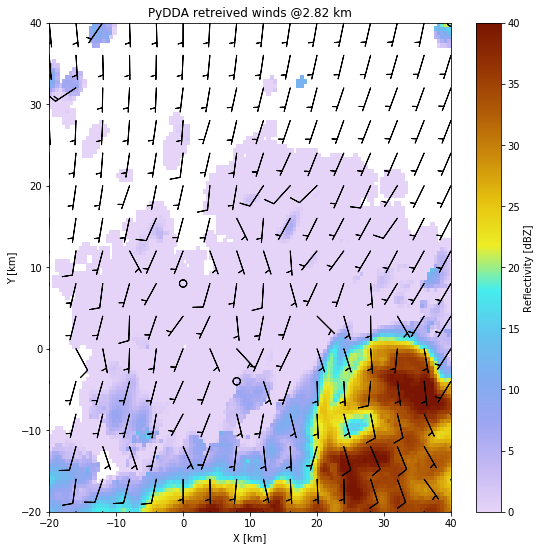

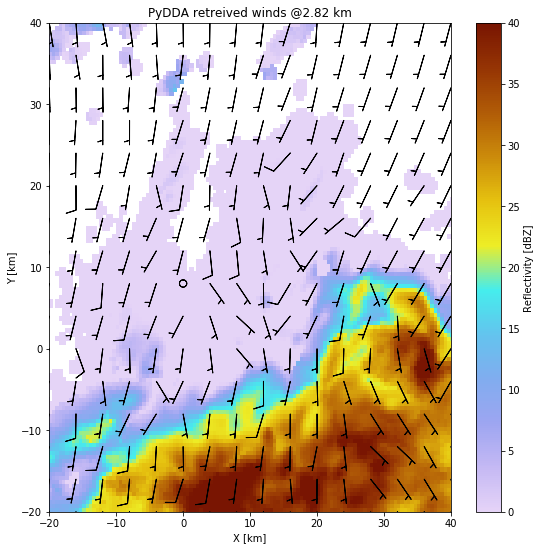

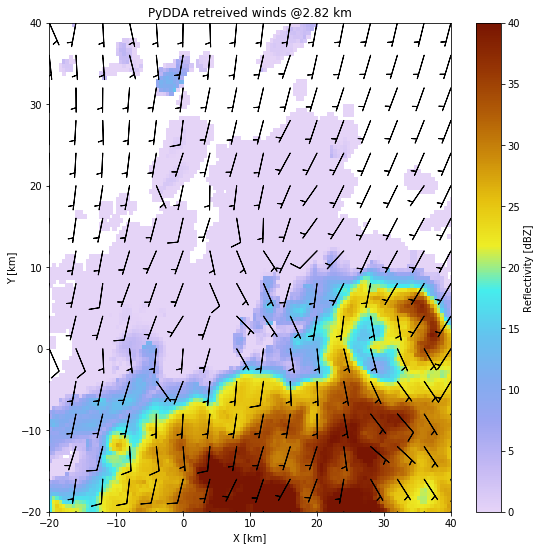

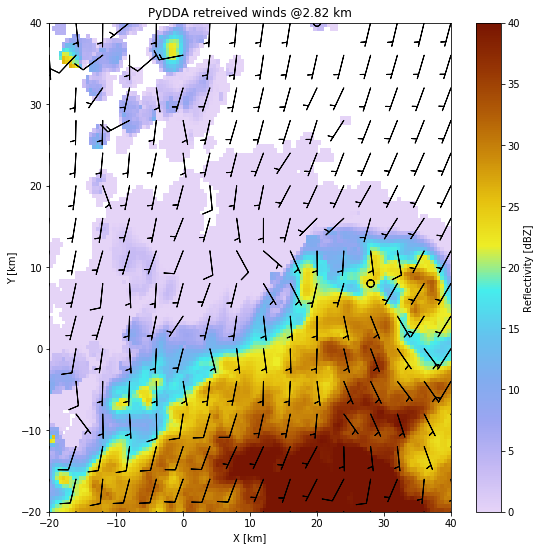

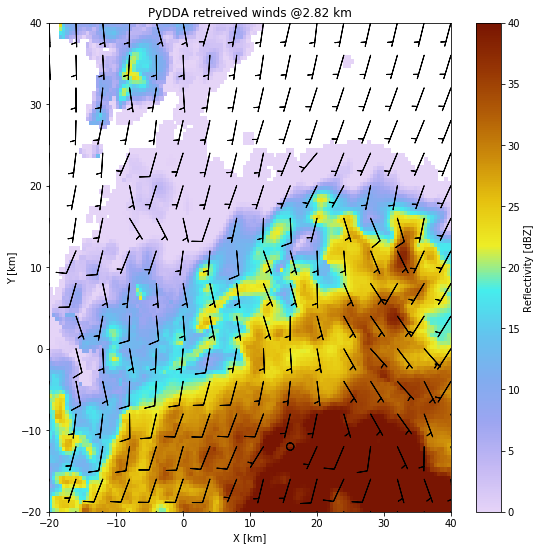

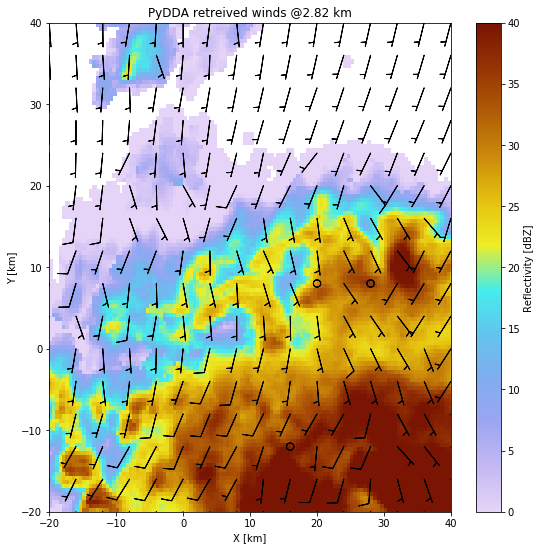

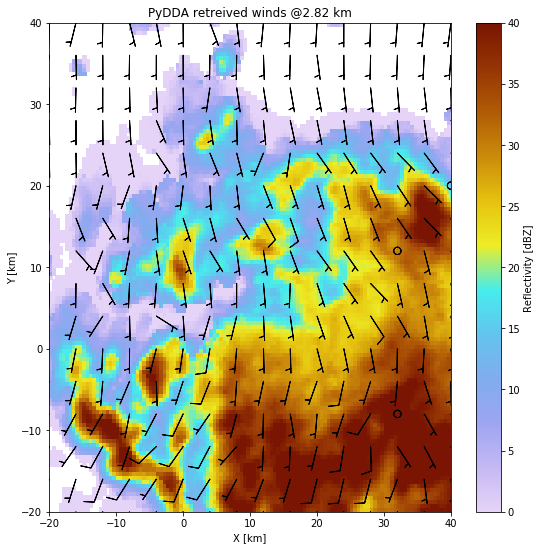

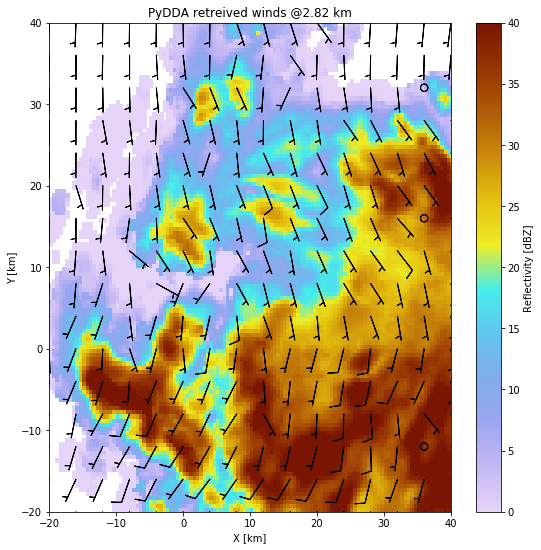

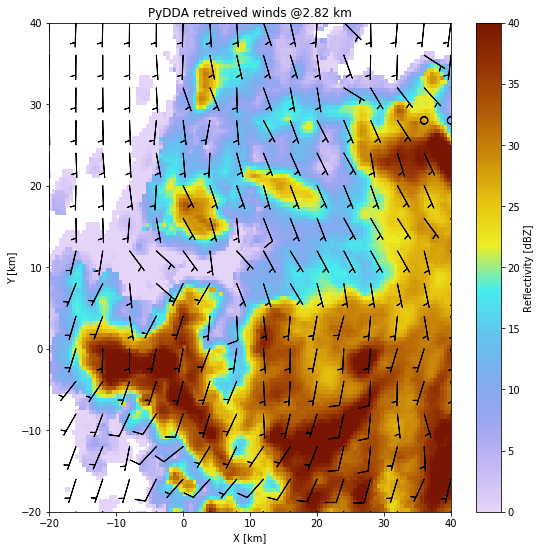

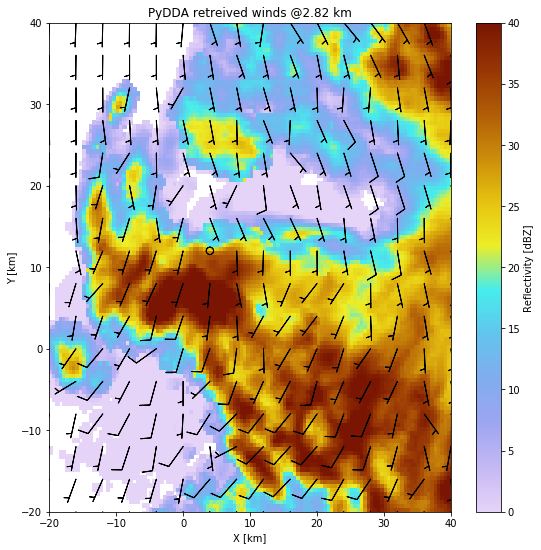

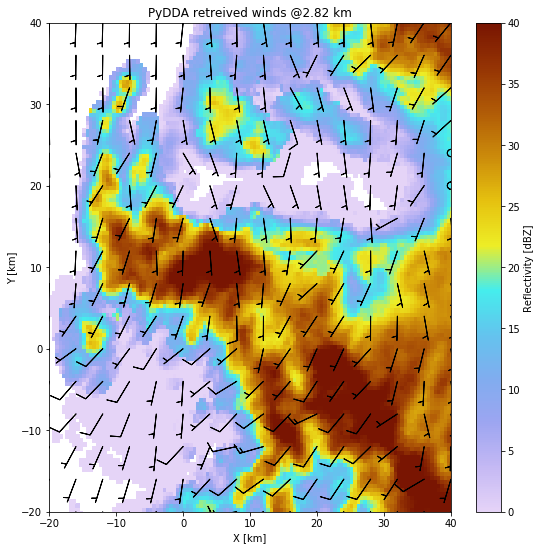

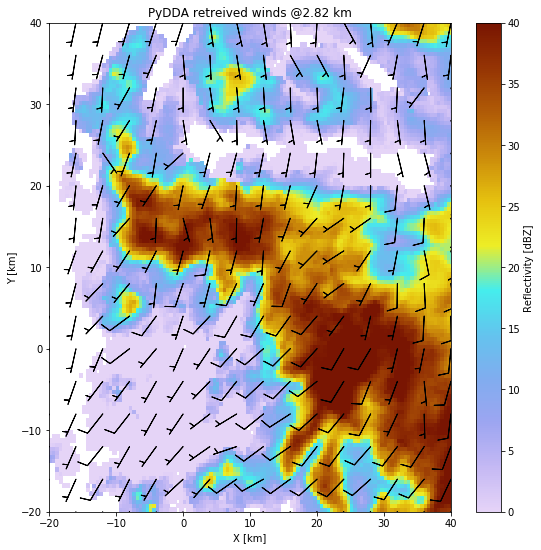

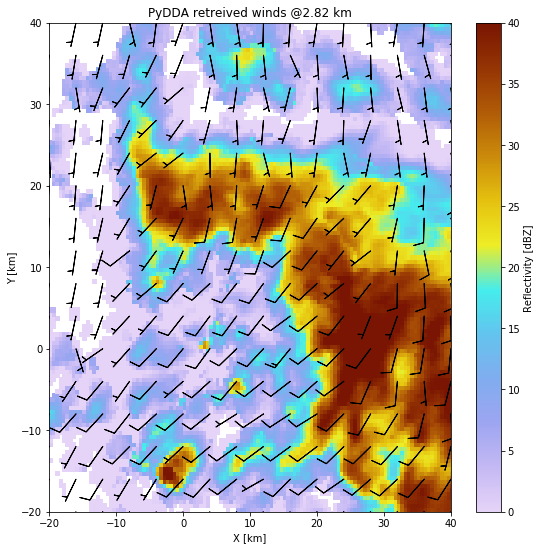

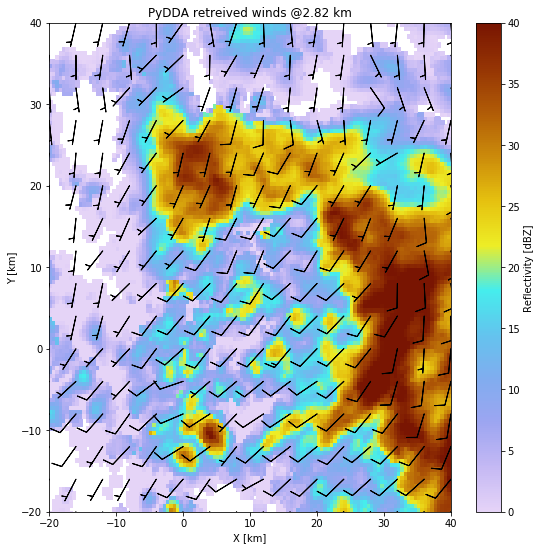

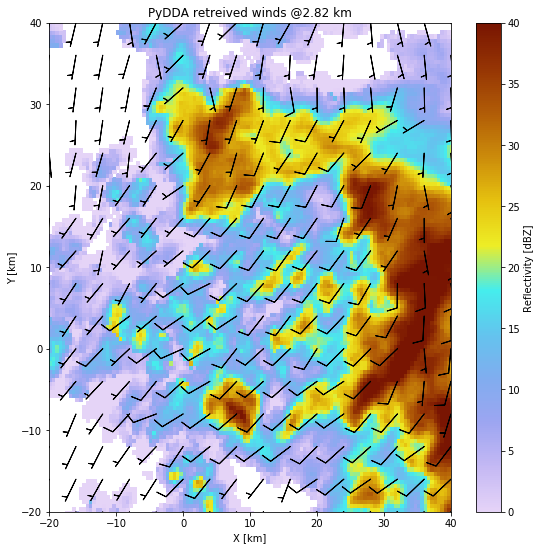

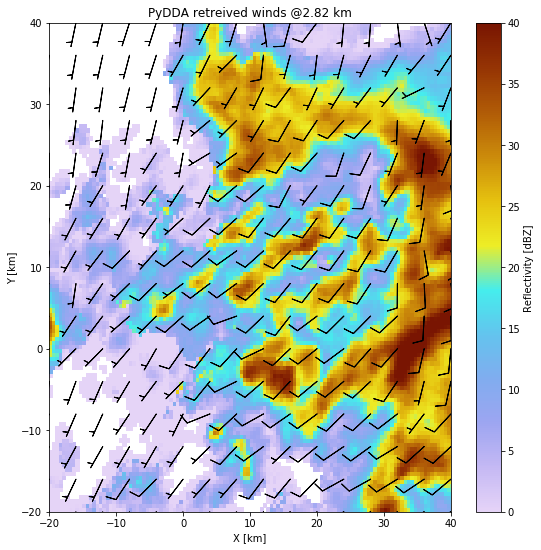

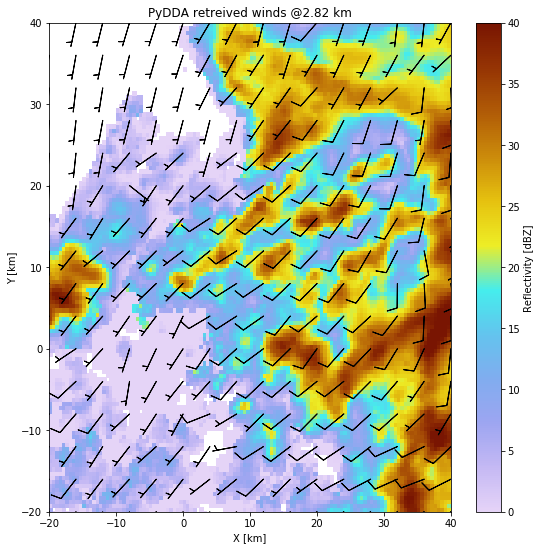

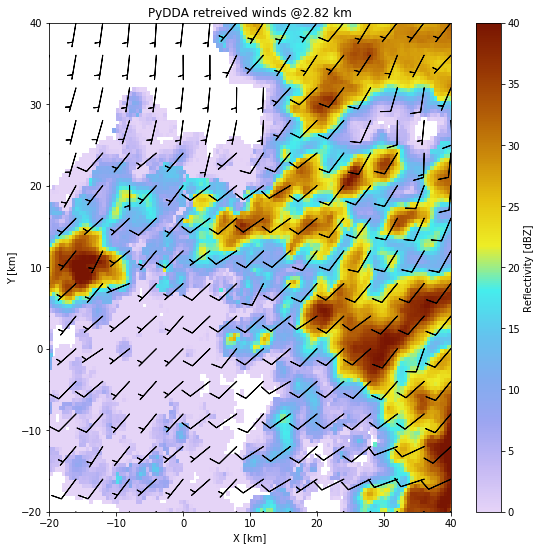

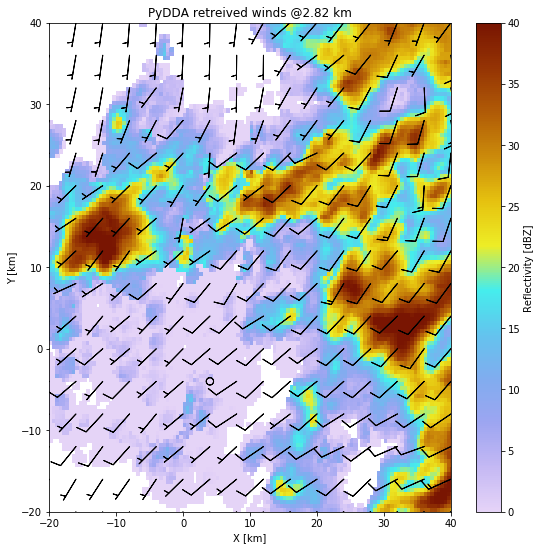

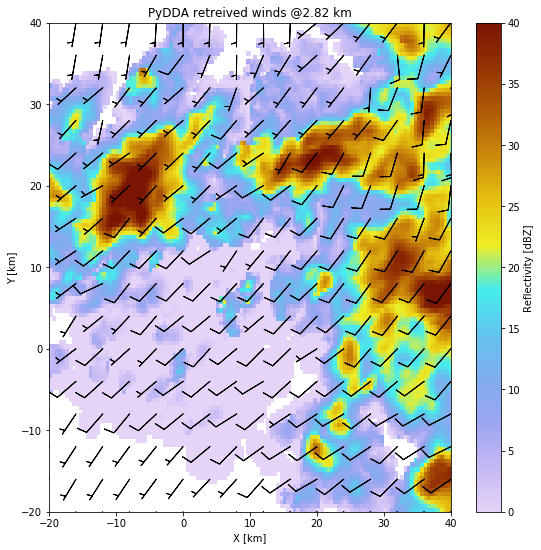

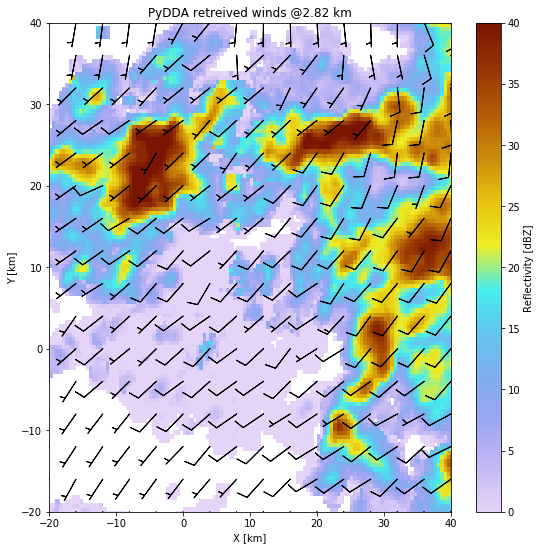

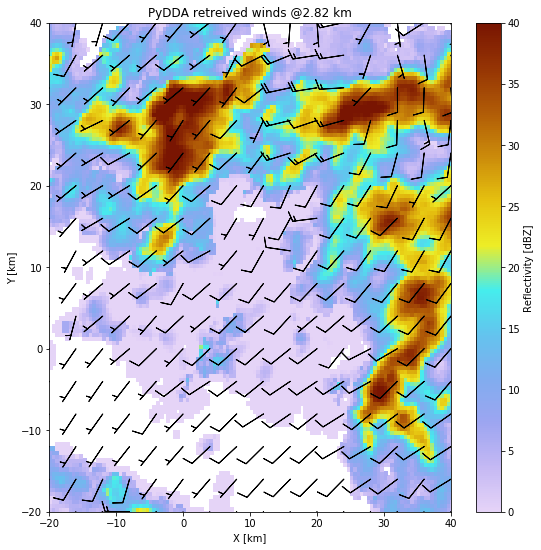

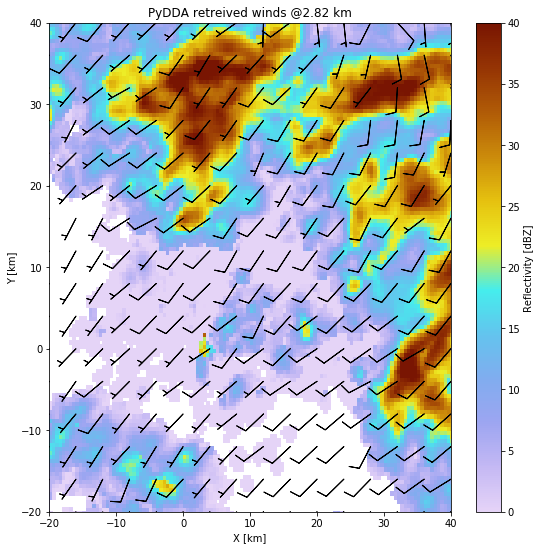

In [7]:
for i in range(len(grid0s)):
    g0 = pyart.io.read_grid(grid0s[i])
    g1 = pyart.io.read_grid(grid1s[i])
    g2 = pyart.io.read_grid(grid2s[i])
    plt.figure(figsize=(9,9))
    ax = pydda.vis.plot_horiz_xsection_barbs([g0, g1, g2], level=5, show_lobes=False, bg_grid_no=-1,
                                             barb_spacing_x_km=4, barb_spacing_y_km=4, 
                                             vmin=0, vmax=40)
    ax.set_xlim([-20,40])
    ax.set_ylim([-20,40])
    plt.savefig(grid0s[i][-15:] + '.png')

In [71]:
del futures

In [9]:
pydda.vis.plot_horiz_xsection_quiver_map?

In [97]:
print(the_inds)

(array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77]),)
